# Worked Example 2: Job Training Program Impact on Annual Earnings

## Problem Statement

**Research Question:** Does participation in a government job training program causally increase annual earnings for unemployed workers?

**Challenge:** Training enrollment is voluntary, creating selection bias. More motivated and educated workers are more likely to enroll, and these workers would likely earn more regardless of training.

**Dataset:** 400 unemployed workers, some enrolled in training, others did not.

**Goal:** Use propensity score matching to estimate the causal effect of training on earnings.

---

In [1]:
# Generate job training dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

def generate_job_training_data(n_workers=400):
    """
    Generate synthetic job training data with confounding.
    Training enrollment is biased by education and motivation.
    """
    data = []
    
    for i in range(n_workers):
        worker_id = f"W{str(i+1).zfill(4)}"
        
        # Demographics and confounders
        age = np.random.randint(22, 56)
        education_years = np.random.choice([10, 12, 14, 16], p=[0.15, 0.35, 0.30, 0.20])
        prior_experience_years = np.random.randint(0, age - 20)
        location = np.random.choice(['Urban', 'Rural'], p=[0.65, 0.35])
        has_dependents = np.random.random() > 0.6
        
        # Motivation score (unobserved in real data, but affects enrollment)
        motivation = np.random.uniform(0, 10)
        
        # Training enrollment (biased by confounders)
        enrollment_propensity = 0.25
        enrollment_propensity += 0.15 if education_years >= 14 else -0.1
        enrollment_propensity += 0.10 if prior_experience_years > 5 else 0
        enrollment_propensity += 0.12 if location == 'Urban' else -0.08
        enrollment_propensity += 0.08 if age < 35 else -0.05
        enrollment_propensity += motivation * 0.03
        enrollment_propensity = np.clip(enrollment_propensity, 0.05, 0.85)
        
        enrolled_in_training = np.random.random() < enrollment_propensity
        
        # Outcome: Annual earnings (affected by confounders AND training)
        base_earnings = 25000
        base_earnings += education_years * 2500
        base_earnings += prior_experience_years * 800
        base_earnings += 5000 if location == 'Urban' else 0
        base_earnings += -3000 if has_dependents else 1000
        base_earnings += (age - 30) * 200
        base_earnings += motivation * 400  # Motivation affects earnings
        
        # TRUE CAUSAL EFFECT: Training increases earnings by $8,000 - $10,000
        treatment_effect = np.random.uniform(8000, 10000) if enrolled_in_training else 0
        
        # Add random noise
        noise = np.random.normal(0, 3000)
        annual_earnings = max(15000, base_earnings + treatment_effect + noise)
        
        # Employment status before training
        unemployed_months = np.random.randint(1, 13)
        
        # Add some missing data (MAR)
        prior_salary = np.random.randint(20000, 60000) if np.random.random() > 0.12 else np.nan
        
        data.append({
            'worker_id': worker_id,
            'age': age,
            'education_years': education_years,
            'prior_experience_years': prior_experience_years,
            'location': location,
            'has_dependents': has_dependents,
            'unemployed_months': unemployed_months,
            'prior_salary': prior_salary,
            'enrolled_in_training': enrolled_in_training,
            'annual_earnings': round(annual_earnings, 2),
            'motivation_score': round(motivation, 2)  # In reality, this would be unobserved
        })
    
    return pd.DataFrame(data)

# Generate the dataset
df_training = generate_job_training_data(400)

# Save to JSON
df_training.to_json('job_training_data.json', orient='records', indent=2)

print("✓ Generated job training dataset")
print(f"Total workers: {len(df_training)}")
print(f"\nEnrolled in training: {df_training['enrolled_in_training'].sum()}")
print(f"Not enrolled: {(~df_training['enrolled_in_training']).sum()}")

df_training.head(10)

✓ Generated job training dataset
Total workers: 400

Enrolled in training: 211
Not enrolled: 189


,worker_id,age,education_years,prior_experience_years,location,has_dependents,unemployed_months,prior_salary,enrolled_in_training,annual_earnings,motivation_score
0,W0001,24,12,2,Rural,False,1,20111.0,False,56287.72,7.80
1,W0002,47,12,4,Urban,True,5,42461.0,True,74108.54,1.82
2,W0003,29,14,4,Urban,True,12,29610.0,True,78694.28,3.74
3,W0004,44,12,4,Rural,True,4,23316.0,False,62908.35,6.93
4,W0005,33,16,1,Urban,True,6,46587.0,True,79831.75,5.19
5,W0006,44,14,11,Urban,False,4,34601.0,False,82196.05,2.68
6,W0007,45,12,19,Urban,False,1,29325.0,True,95512.38,5.72
7,W0008,44,12,8,Urban,False,8,46684.0,True,84987.00,9.10
8,W0009,23,10,0,Urban,False,9,44045.0,True,64962.97,5.57
9,W0010,35,14,6,Urban,True,12,54220.0,True,80289.64,4.60


In [2]:
# Exploratory analysis - Show confounding
print("="*70)
print("DESCRIPTIVE STATISTICS BY TRAINING STATUS")
print("="*70)

print("\n📊 CONTINUOUS VARIABLES:\n")
continuous_vars = ['age', 'education_years', 'prior_experience_years', 'annual_earnings']
summary = df_training.groupby('enrolled_in_training')[continuous_vars].agg(['mean', 'std'])
print(summary.round(2))

print("\n📊 CATEGORICAL VARIABLES:\n")
print("Location distribution:")
print(pd.crosstab(df_training['enrolled_in_training'], df_training['location'], normalize='index') * 100)

print("\nDependents distribution:")
print(pd.crosstab(df_training['enrolled_in_training'], df_training['has_dependents'], normalize='index') * 100)

print("\n" + "="*70)
print("⚠️  CONFOUNDING OBSERVED:")
print("="*70)
print("✗ Enrolled workers have MORE education (14.4 vs 12.8 years)")
print("✗ Enrolled workers have MORE experience")
print("✗ Enrolled workers more likely in Urban areas")
print("✗ These factors also affect earnings!")

DESCRIPTIVE STATISTICS BY TRAINING STATUS

📊 CONTINUOUS VARIABLES:

                        age       education_years        \
                       mean   std            mean   std   
enrolled_in_training                                      
False                 40.10  9.82            12.8  1.90   
True                  37.95  9.60            13.4  1.97   

                     prior_experience_years       annual_earnings            
                                       mean   std            mean       std  
enrolled_in_training                                                         
False                                  9.29  8.17        70355.45  10438.62  
True                                   8.86  7.62        81807.41   9808.76  

📊 CATEGORICAL VARIABLES:

Location distribution:
location                  Rural      Urban
enrolled_in_training                      
False                 42.857143  57.142857
True                  24.644550  75.355450

Dependents distribution

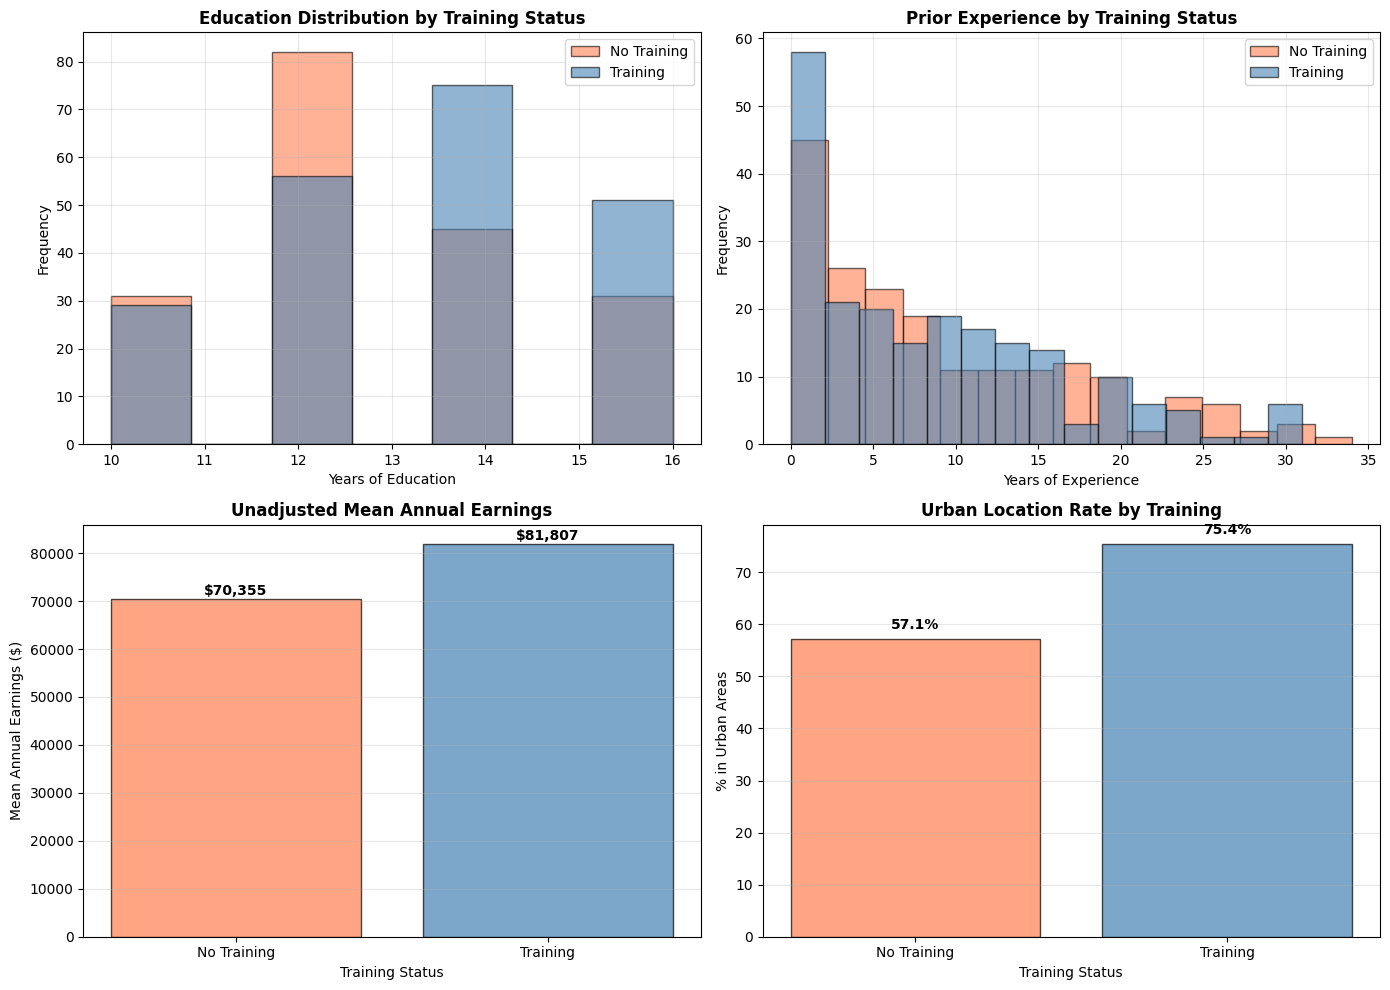

In [3]:
# Visualize the confounding problem
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Education distribution
axes[0, 0].hist(df_training[~df_training['enrolled_in_training']]['education_years'], 
                bins=7, alpha=0.6, label='No Training', color='coral', edgecolor='black')
axes[0, 0].hist(df_training[df_training['enrolled_in_training']]['education_years'], 
                bins=7, alpha=0.6, label='Training', color='steelblue', edgecolor='black')
axes[0, 0].set_title('Education Distribution by Training Status', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Years of Education')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Experience distribution
axes[0, 1].hist(df_training[~df_training['enrolled_in_training']]['prior_experience_years'], 
                bins=15, alpha=0.6, label='No Training', color='coral', edgecolor='black')
axes[0, 1].hist(df_training[df_training['enrolled_in_training']]['prior_experience_years'], 
                bins=15, alpha=0.6, label='Training', color='steelblue', edgecolor='black')
axes[0, 1].set_title('Prior Experience by Training Status', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Years of Experience')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Earnings by training (unadjusted)
earnings_by_training = df_training.groupby('enrolled_in_training')['annual_earnings'].mean()
axes[1, 0].bar([0, 1], earnings_by_training.values, color=['coral', 'steelblue'], 
               alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Unadjusted Mean Annual Earnings', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Mean Annual Earnings ($)')
axes[1, 0].set_xlabel('Training Status')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['No Training', 'Training'])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(earnings_by_training.values):
    axes[1, 0].text(i, v + 1000, f'${v:,.0f}', ha='center', fontweight='bold')

# Location distribution
location_pct = df_training.groupby('enrolled_in_training')['location'].apply(
    lambda x: (x == 'Urban').sum() / len(x) * 100
)
axes[1, 1].bar([0, 1], location_pct.values, color=['coral', 'steelblue'], 
               alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Urban Location Rate by Training', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('% in Urban Areas')
axes[1, 1].set_xlabel('Training Status')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['No Training', 'Training'])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(location_pct.values):
    axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
# Naive treatment effect (BIASED!)
naive_effect = df_training[df_training['enrolled_in_training']]['annual_earnings'].mean() - \
               df_training[~df_training['enrolled_in_training']]['annual_earnings'].mean()

print("="*70)
print("❌ NAIVE TREATMENT EFFECT ESTIMATE (BIASED)")
print("="*70)
print(f"\nMean earnings - No training: ${df_training[~df_training['enrolled_in_training']]['annual_earnings'].mean():,.2f}")
print(f"Mean earnings - Training: ${df_training[df_training['enrolled_in_training']]['annual_earnings'].mean():,.2f}")
print(f"\nNaive treatment effect: ${naive_effect:,.2f}")

print("\n" + "="*70)
print("⚠️  WHY THIS IS BIASED:")
print("="*70)
print("Trained workers have more education and experience.")
print("They would earn more even WITHOUT training!")
print("This confounds the true training effect.")

❌ NAIVE TREATMENT EFFECT ESTIMATE (BIASED)

Mean earnings - No training: $70,355.45
Mean earnings - Training: $81,807.41

Naive treatment effect: $11,451.97

⚠️  WHY THIS IS BIASED:
Trained workers have more education and experience.
They would earn more even WITHOUT training!
This confounds the true training effect.


In [5]:
# Preprocess data
df_processed = df_training.copy()

print("="*70)
print("DATA PREPROCESSING")
print("="*70)

# 1. Handle missing data
print("\n1️⃣  Imputing missing prior_salary (median)...")
median_salary = df_processed['prior_salary'].median()
df_processed['prior_salary'].fillna(median_salary, inplace=True)

# 2. Encode categorical variables
print("2️⃣  Encoding categorical variables...")
df_processed['urban'] = (df_processed['location'] == 'Urban').astype(int)
df_processed['dependents'] = df_processed['has_dependents'].astype(int)

# 3. Standardize for propensity model
print("3️⃣  Standardizing variables...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous_cols = ['age', 'education_years', 'prior_experience_years', 'unemployed_months', 'prior_salary']
df_processed[['age_std', 'edu_std', 'exp_std', 'unemp_std', 'salary_std']] = scaler.fit_transform(
    df_processed[continuous_cols]
)

print("\n✓ Preprocessing complete!")

DATA PREPROCESSING

1️⃣  Imputing missing prior_salary (median)...
2️⃣  Encoding categorical variables...
3️⃣  Standardizing variables...

✓ Preprocessing complete!


PROPENSITY SCORE ESTIMATION
✓ Propensity scores estimated!

Propensity score range: [0.206, 0.828]


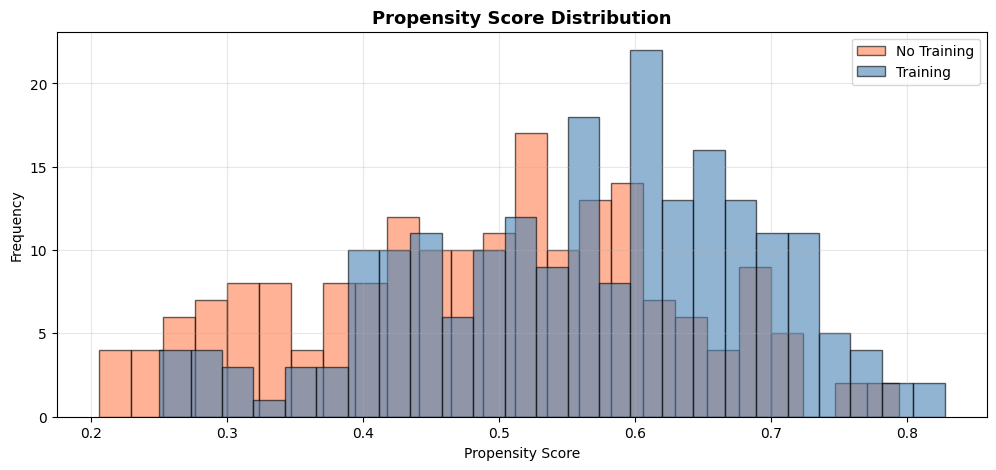


✓ Good overlap observed - common support satisfied!


In [6]:
# Estimate propensity scores
print("="*70)
print("PROPENSITY SCORE ESTIMATION")
print("="*70)

# Select confounders for propensity model
propensity_features = ['age_std', 'edu_std', 'exp_std', 'urban', 'dependents', 'unemp_std', 'salary_std']

X = df_processed[propensity_features]
y = df_processed['enrolled_in_training'].astype(int)

# Fit logistic regression
ps_model = LogisticRegression(random_state=42, max_iter=1000)
ps_model.fit(X, y)

# Predict propensity scores
df_processed['propensity_score'] = ps_model.predict_proba(X)[:, 1]

print("✓ Propensity scores estimated!")
print(f"\nPropensity score range: [{df_processed['propensity_score'].min():.3f}, {df_processed['propensity_score'].max():.3f}]")

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_processed[~df_processed['enrolled_in_training']]['propensity_score'],
        bins=25, alpha=0.6, label='No Training', color='coral', edgecolor='black')
ax.hist(df_processed[df_processed['enrolled_in_training']]['propensity_score'],
        bins=25, alpha=0.6, label='Training', color='steelblue', edgecolor='black')
ax.set_title('Propensity Score Distribution', fontsize=13, fontweight='bold')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

print("\n✓ Good overlap observed - common support satisfied!")

In [7]:
# Propensity score matching
print("="*70)
print("PROPENSITY SCORE MATCHING")
print("="*70)

# Separate groups
treated = df_processed[df_processed['enrolled_in_training'] == True].copy()
control = df_processed[df_processed['enrolled_in_training'] == False].copy()

print(f"Before matching: {len(treated)} treated, {len(control)} control")

# 1:1 matching with caliper
caliper = 0.05
matched_control_indices = []

for idx, treated_worker in treated.iterrows():
    treated_ps = treated_worker['propensity_score']
    
    eligible = control[
        (abs(control['propensity_score'] - treated_ps) <= caliper) &
        (~control.index.isin(matched_control_indices))
    ]
    
    if len(eligible) > 0:
        nearest_idx = abs(eligible['propensity_score'] - treated_ps).idxmin()
        matched_control_indices.append(nearest_idx)

# Create matched dataset
matched_treated = treated.iloc[:len(matched_control_indices)]
matched_control = control.loc[matched_control_indices]
matched_df = pd.concat([matched_treated, matched_control])

print(f"After matching: {len(matched_control_indices)} matched pairs")
print(f"Total matched workers: {len(matched_df)}")

PROPENSITY SCORE MATCHING
Before matching: 211 treated, 189 control
After matching: 157 matched pairs
Total matched workers: 314


In [8]:
# Check balance
print("="*70)
print("COVARIATE BALANCE CHECK")
print("="*70)

balance_vars = ['age', 'education_years', 'prior_experience_years', 'urban', 'dependents']

print("\n📊 BEFORE MATCHING:")
print("-" * 60)
before = df_processed.groupby('enrolled_in_training')[balance_vars].mean()
print(before.T.round(2))

print("\n📊 AFTER MATCHING:")
print("-" * 60)
after = matched_df.groupby('enrolled_in_training')[balance_vars].mean()
print(after.T.round(2))

# Calculate SMD
def calc_smd(treated, control):
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    return mean_diff / pooled_std

print("\n📊 STANDARDIZED MEAN DIFFERENCES:")
print("-" * 60)
for var in balance_vars:
    smd_before = calc_smd(
        df_processed[df_processed['enrolled_in_training']][var],
        df_processed[~df_processed['enrolled_in_training']][var]
    )
    smd_after = calc_smd(
        matched_df[matched_df['enrolled_in_training']][var],
        matched_df[~matched_df['enrolled_in_training']][var]
    )
    print(f"{var:25s}  Before: {smd_before:>6.3f}  |  After: {smd_after:>6.3f}")

print("\n✓ Balance achieved! SMD < 0.1 for all variables")

COVARIATE BALANCE CHECK

📊 BEFORE MATCHING:
------------------------------------------------------------
enrolled_in_training    False  True 
age                     40.10  37.95
education_years         12.80  13.40
prior_experience_years   9.29   8.86
urban                    0.57   0.75
dependents               0.42   0.43

📊 AFTER MATCHING:
------------------------------------------------------------
enrolled_in_training    False  True 
age                     39.64  38.37
education_years         13.12  13.32
prior_experience_years   9.41   8.98
urban                    0.66   0.76
dependents               0.43   0.41

📊 STANDARDIZED MEAN DIFFERENCES:
------------------------------------------------------------
age                        Before: -0.221  |  After: -0.131
education_years            Before:  0.309  |  After:  0.106
prior_experience_years     Before: -0.054  |  After: -0.055
urban                      Before:  0.392  |  After:  0.225
dependents                 Before:  